In [0]:
import numpy as np
from progressbar import progressbar as pb
import itertools
import collections
import re
from sklearn.model_selection import train_test_split as TTS

In [0]:
import pandas as pd
import numpy as np
from progressbar import progressbar as pb
df = pd.read_csv('all_data_fixed3.csv')
df.head()

,0,1,2,3,4,5
0,Совещательный орган при императоре в начале XX в,Сенат,Государственный совет,Консилия министров,Верховный тайный совет,2
1,Министр внутренних дел с 1904 г либерал автор ...,Лорис Меликов,Святополк Мирский,Милюков,Витте,2
2,Какое из названных событий произошло 27 января...,подрыв флагманского корабля Петропавловск,высадка японских войск на Ляодунском полуострове,героический бой Варяга и Корейца,заключение Портсмутского мирного договора,3
3,Что из названного относится к результатам перв...,появление многопартийности,формирование конституционной монархии,ликвидация сословного строя,введение рабочего контроля за производством,1
4,Для выхода из экономического кризиса вызванног...,ввело 8 часовой рабочий день в промышленности,ликвидировало помещичье землевладение,отменило выкупные платежи,ввело продовольственную разверстку,4


In [0]:
for i in pb(range(df.shape[0])):
    for j in range(df.shape[1]-1):
        df.iloc[i,j] = df.iloc[i,j].lower()

100% (5330 of 5330) |####################| Elapsed Time: 0:00:30 Time:  0:00:30


In [0]:
corpus = []

for i in pb(range(df.shape[0])):
    for j in range(df.shape[1]-1):
        corpus.append(df.iloc[i,j])

100% (5330 of 5330) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


In [0]:
samples = np.array(df.drop('5', 1))
target = np.array(df['5'])

X_train, X_test, y_train, y_test = TTS(samples, target, test_size=0.25, random_state=4)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X = X.toarray()
X.shape

(26650, 23800)

In [0]:
def get_batch(X_val, y_val, batch_sz=16):
    X_batches, y_batches = [], []
    vals = np.hstack((X_val, y_val[:,np.newaxis]))
    np.random.shuffle(vals)
    
    X_val, y_val = vals[:,:-1], vals[:,-1]
    
    for i in range(len(X_val) // batch_sz):
        X_temp, y_temp = [], []
        for j in range(batch_sz):
            X_temp.append(vectorizer.transform(X_val[i*batch_sz + j]).toarray().reshape(1,-1)[0])
            y_temp.append(y_val[i*batch_sz + j] - 1)

        X_batches.append(np.array(X_temp))
        y_batches.append(np.array(y_temp))
        
    rest = len(X_val) % (batch_sz)
    X_temp, y_temp = [], []
    
    for i in range(rest):
        X_temp.append(vectorizer.transform(X_val[-rest + i]).toarray().reshape(1,-1)[0])
        y_temp.append(y_val[-rest + i] - 1)
        
    X_batches.append(np.array(X_temp))
    y_batches.append(np.array(y_temp))
    
    return np.array(X_batches), np.array(y_batches)

In [0]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity as cos

In [0]:
class DSSMNet(nn.Module):
    def __init__(self, bow_size):
        super().__init__()
        self.bow_size = bow_size
        self.linear_1_1 = nn.Linear(bow_size, 300)
        self.linear_1_2 = nn.Linear(300, 300)
        self.linear_1_3 = nn.Linear(300, 128)
        
        self.linear_2_1 = nn.Linear(bow_size, 300)
        self.linear_2_2 = nn.Linear(300, 300)
        self.linear_2_3 = nn.Linear(300, 128)      
        
    def forward(self, sample):
        bow_size = self.bow_size
        inputs = [sample[:,:bow_size], sample[:,bow_size:bow_size*2], \
                  sample[:,bow_size*2:bow_size*3], sample[:,bow_size*3:bow_size*4],\
                  sample[:,bow_size*4:]]
        
        outputs = torch.Tensor().type(torch.cuda.FloatTensor)
        
        question = torch.tanh(self.linear_1_1(inputs[0]))
        question = torch.tanh(self.linear_1_2(question))
        question = torch.tanh(self.linear_1_3(question))
        outputs = torch.cat((outputs, question.unsqueeze(0)), dim=0)
        
        for answer in inputs[1:]:
          answer = torch.tanh(self.linear_2_1(answer))
          answer = torch.tanh(self.linear_2_2(answer))
          answer = torch.tanh(self.linear_2_3(answer))
          outputs = torch.cat((outputs, answer.unsqueeze(0)), dim=0)
        
        cosines = torch.Tensor().type(torch.cuda.FloatTensor)
        
        for i in range(1,len(outputs)):
            cosines = torch.cat((cosines, F.cosine_similarity(outputs[0], outputs[i], dim=1).unsqueeze(0)))
            
        probs = F.softmax(cosines.view(-1,4))
        
        return probs     

In [0]:
model = DSSMNet(X.shape[1])
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
epochs = 25

In [0]:
def train(model, optimizer, X_train, y_train, batch_size):
    train_loss, train_acc = [], []
    model.train()
    X_batches, y_batches = get_batch(X_train, y_train, batch_size)
    
    for batch in zip(X_batches, y_batches):
        X_batch, y_batch = batch
        X_batch = torch.from_numpy(X_batch).type(torch.cuda.FloatTensor)
        y_batch = torch.from_numpy(y_batch).type(torch.cuda.LongTensor)
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        train_loss.append(loss.item())
        
        max_ind = y_pred.max(1, keepdim=True)[1]
        target_matches = torch.eq(max_ind, y_batch.data.view(len(y_batch), 1))
        accuracy = torch.sum(target_matches).cpu().numpy() / len(y_batch)
        train_acc.append(accuracy)
        
        loss.backward()
        optimizer.step()
        
    return np.mean(train_loss), np.mean(train_acc)

In [0]:
def validate(model, optimizer, X_test, y_test, batch_size):
    val_loss, val_acc = [], []
    model.eval()
    X_batches, y_batches = get_batch(X_test, y_test, batch_size)
    
    for batch in zip(X_batches, y_batches):
        X_batch, y_batch = batch
        X_batch = torch.from_numpy(X_batch).type(torch.cuda.FloatTensor)
        y_batch = torch.from_numpy(y_batch).type(torch.cuda.LongTensor)
        
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        val_loss.append(loss.item())
        
        max_ind = y_pred.max(1, keepdim=True)[1]
        target_matches = torch.eq(max_ind, y_batch.data.view(len(y_batch), 1))
        accuracy = torch.sum(target_matches).cpu().numpy() / len(y_batch)
        val_acc.append(accuracy)
         
    return np.mean(val_loss), np.mean(val_acc)

Epoch 24:
Train loss: 1.386286107320634
Train accuracy: 0.2532840722495895
Validation loss: 1.3864111247516813
Validation accuracy: 0.23779761904761906


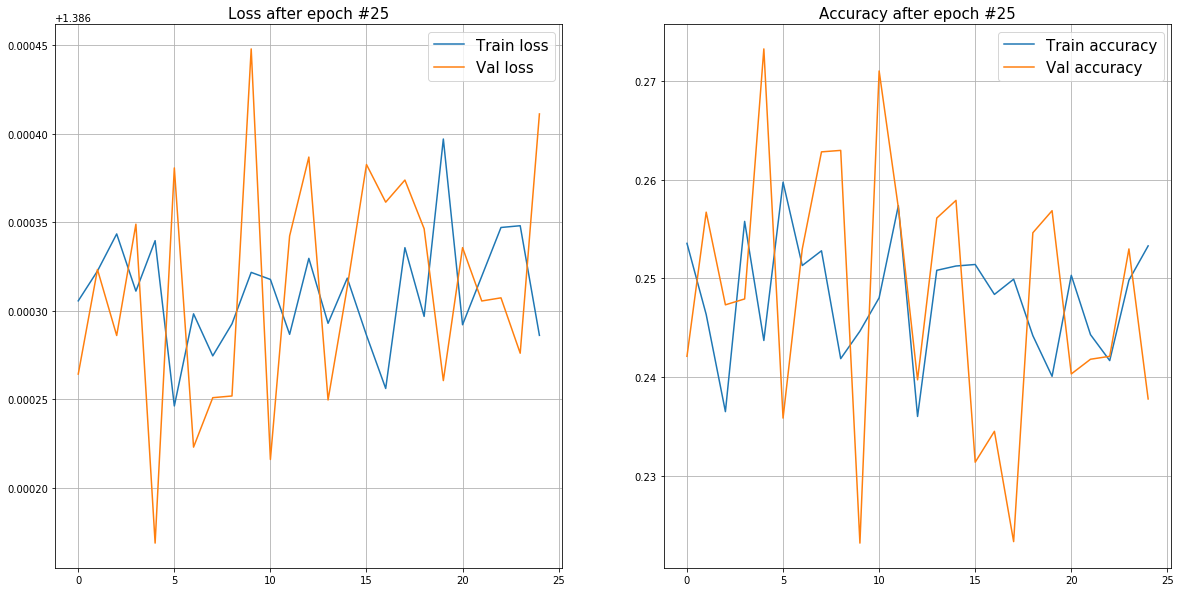

100% (25 of 25) |########################| Elapsed Time: 0:03:47 Time:  0:03:47


In [0]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
all_train_loss, all_val_loss = [], []
all_train_acc, all_val_acc = [], []


for epoch in pb(range(epochs)):
    cur_train = train(model, optimizer, X_train, y_train, 64)
    cur_val = validate(model, optimizer, X_test, y_test, 16)
    all_train_loss.append(cur_train[0])
    all_train_acc.append(cur_train[1])
    all_val_loss.append(cur_val[0])
    all_val_acc.append(cur_val[1])
    clear_output()
    print('Epoch {}:'.format(epoch))
    print("Train loss: {}".format(cur_train[0]))
    print("Train accuracy: {}".format(cur_train[1]))
    print("Validation loss: {}".format(cur_val[0]))
    print("Validation accuracy: {}".format(cur_val[1]))
    
    f, axarr = plt.subplots(1,2, figsize=(20,10))
    
    axarr[0].plot(all_train_loss, label='Train loss')
    axarr[0].plot(all_val_loss, label='Val loss')
    axarr[0].grid()
    axarr[0].legend(fontsize=15)
    axarr[0].set_title('Loss after epoch #{}'.format(epoch+1), size=15)

    axarr[1].plot(all_train_acc, label='Train accuracy')
    axarr[1].plot(all_val_acc, label='Val accuracy')
    axarr[1].grid()
    axarr[1].legend(fontsize=15)
    axarr[1].set_title('Accuracy after epoch #{}'.format(epoch+1), size=15)
    plt.show()